# Assignment 6

### 1.复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [1]:
from __future__ import absolute_import,division,print_function,unicode_literals
import os

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import cProfile

In [2]:
# 检测是否是当前需要的
tf.executing_eagerly()

True

In [3]:
x=[[2.]]
m=tf.matmul(x,x) # 多维矩阵相乘
print('x matumal x ={}'.format(m))

x matumal x =[[4.]]


In [4]:
#Tensor
a=tf.constant([[1,2],
              [3,4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [5]:
#Returns x + y element-wise. 每个元素上都相加
b=tf.add(a,1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
print(a*b) # element-wise multiplication

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [7]:
print(tf.matmul(a,b)) # 矩阵相乘

tf.Tensor(
[[10 13]
 [22 29]], shape=(2, 2), dtype=int32)


In [8]:
import numpy as np
c=np.multiply(a,b)
print(c)

[[ 2  6]
 [12 20]]


In [9]:
print(a.numpy()) # tensor 转换成numpy array

[[1 2]
 [3 4]]


In [10]:
# 自动计算梯度
w=tf.Variable([[1.0]]) #初始变量
#with等同于 tray except finally
with tf.GradientTape() as tape: # 记录自动差异
    loss = w*w #TODO:?
grad = tape.gradient(loss,w)   
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [11]:
#训练模型
import pandas as pd
filename='/Users/xiangjiejie/Mayday/AIStudy/lecture6/mnist.npz'
# filename = './mnist.npz'

(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data(filename)
print('x_train',x_train.shape)
print('y_train',y_train.shape)
x_train=x_train[:10000,:,:]
y_train=y_train[:10000]
x_test=x_test[:10000,:,:]
t_test=y_test[:10000]

x_train (60000, 28, 28)
y_train (60000,)


In [12]:
# 对每个维度上进行归一化
print(x_train.shape,y_train.shape)
x_train=tf.cast(x_train[...,tf.newaxis]/255, tf.float32)
x_test = tf.cast(x_test[...,tf.newaxis]/255, tf.float32)
print(x_train.shape,y_train.shape)
# TODO:增加维度

# 转换成one-hot
y_train=tf.keras.utils.to_categorical(y_train,10) #转换向量类型为二进制类矩阵
y_test=tf.keras.utils.to_categorical(y_test,10)
print(x_train.shape,y_train.shape)

(10000, 28, 28) (10000,)
(10000, 28, 28, 1) (10000,)
(10000, 28, 28, 1) (10000, 10)


In [13]:
# 建网络写法1
# 线性叠加层
mnist_model=tf.keras.Sequential([
#     二维卷积，filter卷积核个数,卷积核大小，激活函数，输入矩阵
    tf.keras.layers.Conv2D(32,[3,3], activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(64,[3,3],activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#     随机去掉一些点
    tf.keras.layers.Dropout(0.25),
#     压平，把多维的输入一维化，卷积层到全连接层的过度
    tf.keras.layers.Flatten(),
#     输出128个维度,TODO:?
    tf.keras.layers.Dense(128, activation='relu'),
#     去过拟合随机概率
    tf.keras.layers.Dropout(0.5),
#     输出10个维度
    tf.keras.layers.Dense(10,activation='softmax')
    
])

In [14]:
mnist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [15]:
# 建网络写法2
# 实例化一个张量
inputs=tf.keras.Input(shape=(None,None,1),name='digits')
conv_1=tf.keras.layers.Conv2D(16,[3,3],activation='relu')(inputs)
conv_2=tf.keras.layers.Conv2D(16,[3,3],activation='relu')(conv_1)
# 平均池化
ave_pool=tf.keras.layers.GlobalAveragePooling2D()(conv_2)
# 输出10个维度
outputs=tf.keras.layers.Dense(10)(ave_pool)
mnist_model_2=tf.keras.Model(inputs=inputs,outputs=outputs)

In [16]:
mnist_model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
global_average_pooling2d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 2,650
Trainable params: 2,650
Non-trainable params: 0
_________________________________________________________________


In [17]:
mnist_model.compile(
#     优化
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
#     损失函数，分类交叉熵
                   loss = tf.keras.losses.categorical_crossentropy,
#     度量方式：精确度
                   metrics = ["accuracy"])

In [18]:
mnist_model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                      optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [19]:
# 训练模型数据
# validation_split 数据分类，shuffle打乱
data=mnist_model.fit(x_train,y_train,batch_size=128,epochs=3, validation_split=0.1,shuffle=True)

Train on 9000 samples, validate on 1000 samples
Epoch 1/3
9000/9000 [==============================] - 8s 880us/sample - loss: 2.3054 - accuracy: 0.1051 - val_loss: 2.2986 - val_accuracy: 0.1510
Epoch 2/3
9000/9000 [==============================] - 7s 805us/sample - loss: 2.2962 - accuracy: 0.1232 - val_loss: 2.2873 - val_accuracy: 0.1770
Epoch 3/3
9000/9000 [==============================] - 7s 763us/sample - loss: 2.2855 - accuracy: 0.1484 - val_loss: 2.2757 - val_accuracy: 0.1970


In [20]:
# mnist_model_2.fit(x_train,y_train,batch_size=128,epochs=3, validation_split=0.1,shuffle=True)

In [21]:
print(x_test.shape)
test_image = tf.cast(x_test[...,tf.newaxis]/255, tf.float32)
test_label=tf.keras.utils.to_categorical(y_test,10)
print(test_image.shape)
test_loss, test_acc = mnist_model.evaluate(test_image,  test_label, verbose=2)

(10000, 28, 28, 1)
(10000, 28, 28, 1, 1)


ValueError: Error when checking input: expected conv2d_input to have 4 dimensions, but got array with shape (10000, 28, 28, 1, 1)

### 2.回答以下理论题目?

#### 1. Compared to FNN, what is the biggest advantage of CNN?

CNN 参数共享，极大减少所需要的参数个数

#### 2. Suppose your input is a 100 by 100 gray image, and you use a convolutional layer with 50 filters that are each 5x5. How many parameters does this hidden layer have (including the bias parameters)? 

94*94*50 * 2

#### 3. What are "local invariant" and "parameter sharing" ?

local invariant:平移不变性，图像识别到的内容平移到其他位置，也能够同样识别出来
parameter shareing: 一个维度上图像信息共用一个卷积核来计算

#### 4. Why we use batch normalization ?

防止梯度消失或者爆炸

#### 5. What problem does dropout try to solve ?

解决训练过程过拟合现象，让预测数据更加接近真实

#### 6.  Is the following statement correct and why ? "Because pooling layers do not have parameters, they do not affect  the backpropagation(derivatives) calculation"

pooling是提取特征的过程

### 3. 实践题

#### 3.1 In the first session of the practical part, you will implement an image classification model using any deep learning libraries that you are familiar with,  which means, except for tensorflow and keras, you can also use pytorch/caffe/... .  The dataset used in this session is the cifar10 which contains 50000 color (RGB) images, each with size 32x32x3.  All 50000 images are classified into ten categories. 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

Load the dataset. 

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


(50000, 32, 32, 3) 50000


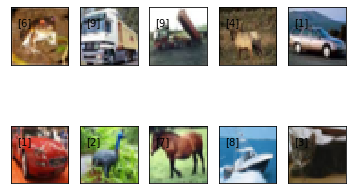

In [4]:
print(train_images.shape,len(train_images))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(train_images[i-1])
    plt.text(3,10,str(train_labels[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

##### It is your time to build your model. Try your best to build a model with good performance on the test set.

In [6]:
print(train_images.shape,train_labels.shape)
print(test_images.shape,test_labels.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [10]:
train_images=train_images[:10000,:,:,:]
train_labels=train_labels[:10000]
test_images=test_images[:10000,:,:,:]
test_labels=test_labels[:10000]
print('a:',train_images.shape,train_labels.shape)

a: (10000, 32, 32, 3) (10000, 1)


In [11]:
train_images.shape[0]

10000

In [132]:
import numpy as np
train_classify = {}

for i in range(1,1000):
    label = str(train_labels[i-1])
    if label not in train_classify:
#         print(train_images[i-1].shape)
        train_classify[label] = {'train_images':train_images[i-1][np.newaxis,...],'train_labels': train_labels[i-1]}
    train_classify[label]['train_images'] = np.vstack([train_classify[label]['train_images'],train_images[i-1][[np.newaxis,...]]])
    train_classify[label]['train_labels'] = np.vstack([train_classify[label]['train_labels'],train_labels[i-1][[np.newaxis,...]]])
#     print(train_classify[label]['train_images'].shape)

    
print(train_classify['[6]']['train_images'].shape)    

(108, 32, 32, 3)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


In [37]:
train_images, test_images = train_images / 255.0, test_images / 255.0
print(train_images.shape, test_images.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [38]:
# train_images0=tf.keras.utils.to_categorical(train_images,10) 
# test_images0=tf.keras.utils.to_categorical(test_images,10)


In [39]:

# 归一化
# train_images1=tf.cast(train_images[...,tf.newaxis]/255, tf.float32)
# test_images1 = tf.cast(test_images[...,tf.newaxis]/255, tf.float32)
# print('b',train_images1.shape,test_images1.shape)


b (50000, 32, 32, 3, 1) (10000, 32, 32, 3, 1)


In [16]:
# 转换成one-hot
train_labels1=tf.keras.utils.to_categorical(train_labels,10) 
test_labels1=tf.keras.utils.to_categorical(test_labels,10)
print('c',train_labels1.shape,test_labels1.shape)


c (10000, 10) (10000, 10)


In [158]:
image_model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,[3,3], padding='same',activation='relu',input_shape=(32,32,3)),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64,[3,3], padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64,[3,3], padding='same',activation='relu'),
#     tf.keras.layers.Dropout(0.25),
#     转全连接网络
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation='softmax')
])
image_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_11 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)              

In [163]:
image_model.compile(
                    optimizer='adam',
#                     loss = tf.keras.losses.categorical_crossentropy,
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics = ["accuracy"]
                   )

# image_model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [151]:
total_val=train_images.shape[0]

In [156]:
# for key in train_classify:

#     train_data=train_classify[key]
    
#     history = image_model.fit_generator(
#         train_data['train_images'],train_data['train_labels'],
# #         steps_per_epoch=train_data['train_images'] ,
#         steps_per_epoch=64,
#         epochs=10,
#         validation_data=(test_images,test_labels),
#         validation_steps=total_val 
#     )
    

TypeError: fit_generator() got multiple values for argument 'steps_per_epoch'

In [164]:
for key in train_classify:

    train_data=train_classify[key]

    history=image_model.fit(train_data['train_images'],train_data['train_labels'],batch_size=64,epochs=10, shuffle=True,
#                validation_data=(test_images, test_labels)
               )
# image_model.fit(train_images,train_labels,batch_size=64,epochs=10, shuffle=True,
#                validation_data=(test_images, test_labels)
#                )

Train on 108 samples
Epoch 1/10
108/108 [==============================] - 0s 4ms/sample - loss: 2.4570 - accuracy: 0.0000e+00
Epoch 2/10
108/108 [==============================] - 0s 636us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 3/10
108/108 [==============================] - 0s 752us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 4/10
108/108 [==============================] - 0s 733us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 5/10
108/108 [==============================] - 0s 699us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 6/10
108/108 [==============================] - 0s 758us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 7/10
108/108 [==============================] - 0s 779us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 8/10
108/108 [==============================] - 0s 777us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 9/10
108/108 [==============================] - 0s 580us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 10/

93/93 [==============================] - 0s 847us/sample - loss: 1.4612 - accuracy: 1.0000
Epoch 6/10
93/93 [==============================] - 0s 818us/sample - loss: 1.4612 - accuracy: 1.0000
Epoch 7/10
93/93 [==============================] - 0s 747us/sample - loss: 1.4612 - accuracy: 1.0000
Epoch 8/10
93/93 [==============================] - 0s 830us/sample - loss: 1.4612 - accuracy: 1.0000
Epoch 9/10
93/93 [==============================] - 0s 902us/sample - loss: 1.4612 - accuracy: 1.0000
Epoch 10/10
93/93 [==============================] - 0s 929us/sample - loss: 1.4612 - accuracy: 1.0000
Train on 85 samples
Epoch 1/10
85/85 [==============================] - 0s 941us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 2/10
85/85 [==============================] - 0s 895us/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 3/10
85/85 [==============================] - 0s 1ms/sample - loss: 2.4612 - accuracy: 0.0000e+00
Epoch 4/10
85/85 [==============================] - 0s 768us/s

In [125]:
history.history

{'loss': [2.4611501693725586,
  2.4611501693725586,
  2.4611501693725586,
  2.4611501693725586,
  2.4611501693725586,
  2.4611501693725586,
  2.4611501693725586,
  2.4611501693725586,
  2.4611501693725586,
  2.4611501693725586],
 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

10000/10000 - 2s - loss: 2.3611 - accuracy: 0.1000


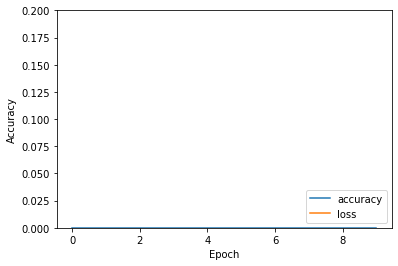

In [127]:
loss = history.history['loss'] # [0.1228,0.1342,0.1060,0.1136,0.1150,0.1010,0.0976,0.0982,0.0964]
accuracy= history.history['accuracy']
# accuracy=history.history['accuracy']
plt.plot(accuracy, label='accuracy')
plt.plot(loss, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.2])
plt.legend(loc='lower right')

test_loss, test_acc = image_model.evaluate(test_images,  test_labels, verbose=2)

In [96]:
test_images.shape
test_images[0].shape

(32, 32, 3)

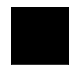

In [106]:
# plt.imshow(train_images[10])

    plt.subplot(2,5,1)
    plt.imshow(train_images[1])
    plt.text(3,10,str(train_labels[1]))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
# for i in range(1,11):
#     plt.subplot(2,5,i)
#     plt.imshow(train_images[i-1])
#     plt.text(3,10,str(train_labels[i-1]))
#     plt.xticks([])
#     plt.yticks([])
# plt.show()    

In [165]:
def predict_image(image):
    tf.cast(image[...,tf.newaxis]/255, tf.float32)
# 转换成one-hot
    image=tf.keras.utils.to_categorical(image,10)
    
    
predict_image(test_images[0].shape)    
    

TypeError: tuple indices must be integers or slices, not tuple

### 4. Optional 

##### Do you want to build a CNN from scratch ? 

In this optianl part, you will build a cnn network step by step.

In [ ]:
import numpy as np
np.random.seed(1)

##### 4.1 Implement a convolution step

Hints: Numpy.sum function might be useful.

In [ ]:
def conv_single_step(a_prev_slice,W,b):
    '''
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    Arguments:
    a_prev_slice: slice of input data (shape=(f,f,n_C_prev))
    W: Weight parameters contained in a window. (shape = (f,f,n_C_prev))
    b: Bias parameters contained in a window. (shape=(1,1,1))
    
    Reutrns:
    
    Z: a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data 
    '''
    # Element-wise product
    s = None
    
    # Sum over s  
    Z = None
    
    # Add bias b to z.
    Z = None
    
    return Z

In [ ]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Use the code above to test your code. If your c
ode is correct, you should be able to get the output shown as below.

<table>
    <tr>
        <td>
            Z
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

##### 4.2 Padding

Hints: Numpy.pad function might be useful.

In [ ]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X: python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad: integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad: padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """

    X_pad = None
    
    return X_pad

In [ ]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
```

##### 4.3 Implement a forward propagation in CNN.

Hints: The formulas to calculate the output shapes are :

$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [ ]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev: output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W: Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b: Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters: python dictionary containing "stride" and "pad"
        
    Returns:
    Z: conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache: cache of values needed for the conv_backward() function
    """
    
    # Get dimensions from A_prev's shape  
    (m, n_H_prev, n_W_prev, n_C_prev) = None
    
    # Get dimensions from W's shape 
    (f, f, n_C_prev, n_C) = None
    
    # Get information from "hparameters" 
    stride = None
    pad = None
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. 
    n_H = None
    n_W = None
    
    # Initialize the output volume Z with zeros. 
    Z = None
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = None
    
    for i in range(None):               # loop over the batch of training examples
        a_prev_pad = None               # Select ith training example's padded activation
        for h in range(None):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = None
            vert_end = None
            
            for w in range(None):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice"
                horiz_start = None
                horiz_end = None
                
                for c in range(None):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). 
                    a_slice_prev = None
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. 
                    weights = None
                    biases = None
                    Z[i, h, w, c] = None
                                        
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
Z's mean =
 0.692360880758
Z[3,2,1] =
 [ -1.28912231   2.27650251   6.61941931   0.95527176   8.25132576
   2.31329639  13.00689405   2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]
```

##### 4.4 Pooling layers

Hints: As there\'s no padding, the formulas binding the output shape of the pooling to the input shape is:

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [ ]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev: Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters: python dictionary containing "f" and "stride"
    mode: the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A: output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache: cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Get dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(None):                         # loop over the training examples
        for h in range(None):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = None
            vert_end = None
            
            for w in range(None):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                horiz_start = None
                horiz_end = None
                
                for c in range (None):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = None
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = None
                    elif mode == "average":
                        A[i, h, w, c] = None
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.46210794  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.14472371  0.90159072  2.10025514]
   [ 1.14472371  0.90159072  1.65980218]
   [ 1.14472371  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  0.84616065  1.2245077 ]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.84616065  1.27375593]
   [ 1.96710175  0.84616065  1.23616403]
   [ 1.62765075  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.96710175  0.86888616  1.23616403]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[ -3.01046719e-02  -3.24021315e-03  -3.36298859e-01]
   [  1.43310483e-01   1.93146751e-01  -4.44905196e-01]
   [  1.28934436e-01   2.22428468e-01   1.25067597e-01]]

  [[ -3.81801899e-01   1.59993515e-02   1.70562706e-01]
   [  4.73707165e-02   2.59244658e-02   9.20338402e-02]
   [  3.97048605e-02   1.57189094e-01   3.45302489e-01]]

  [[ -3.82680519e-01   2.32579951e-01   6.25997903e-01]
   [ -2.47157416e-01  -3.48524998e-04   3.50539717e-01]
   [ -9.52551510e-02   2.68511000e-01   4.66056368e-01]]]


 [[[ -1.73134159e-01   3.23771981e-01  -3.43175716e-01]
   [  3.80634669e-02   7.26706274e-02  -2.30268958e-01]
   [  2.03009393e-02   1.41414785e-01  -1.23158476e-02]]

  [[  4.44976963e-01  -2.61694592e-03  -3.10403073e-01]
   [  5.08114737e-01  -2.34937338e-01  -2.39611830e-01]
   [  1.18726772e-01   1.72552294e-01  -2.21121966e-01]]

  [[  4.29449255e-01   8.44699612e-02  -2.72909051e-01]
   [  6.76351685e-01  -1.20138225e-01  -2.44076712e-01]
   [  1.50774518e-01   2.89111751e-01   1.23238536e-03]]]]
```

####  Congratulations! You hanve finished the assignment 6.  You now understand how convolutional neural networks work.